# Data Preprocessing

In [13]:
import cv2 
import os
import tensorflow as tf 
import keras 
import string
import time 
import random
import matplotlib
import matplotlib.pyplot as plt 

!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [10]:
labels = []
labels.extend(list(string.ascii_uppercase))
labels.extend(["del", "nothing", "space"])
print(labels)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


In [21]:
def sample_images(labels):
    # Create Subplots
    y_size = 12
    if(len(labels)<10):
        y_size = y_size * len(labels) / 10
    fig, axs = plt.subplots(len(labels), 9, figsize=(y_size, 13))

    for i, label in enumerate(labels):
        axs[i, 0].text(0.5, 0.5, label, ha='center', va='center', fontsize=8)
        axs[i, 0].axis('off')

        label_path = os.path.join("/Users/pranavpradhan/Documents/SLR/Dataset/asl_alphabet_train", label)
        list_files = os.listdir(label_path)

        for j in range(8):
            img_label = cv2.imread(os.path.join(label_path, list_files[j]))
            img_label = cv2.cvtColor(img_label, cv2.COLOR_BGR2RGB)
            axs[i, j+1].imshow(img_label)
            axs[i, j+1].axis("off")

    # Title
    plt.suptitle("Sample Images in ASL Alphabet Dataset", x=0.55, y=0.92)

    # Show
    plt.show()


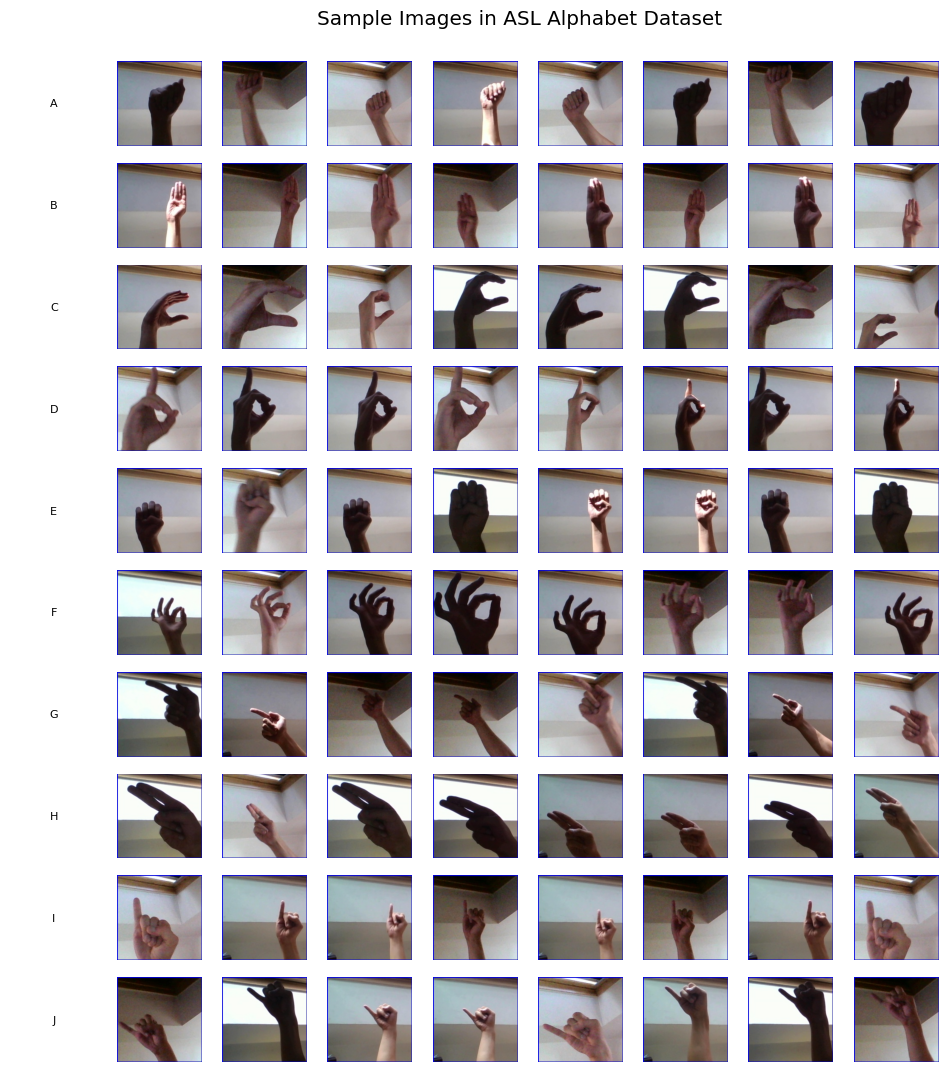

In [22]:
sample_images(labels[:10])
